# Frame Analysis F1 Score Generator

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook tests how good a trained frame-by-frame analysis model is by generating an F1 score for a dataset of squats. 

Input: tuples of the squat videos and trained frame analysis models.

## TOC:
0. [Import Libraries & Setup](#0.-Import-Libraries-&-Setup)
1. [Setup Testing Set](#1.-Setup-Testing-Set)
2. [Evaluate Models](#2.-Evaluate-Models)
    * [Nearest Neighbours](#KNC-Model)
    * [Neural Network](#Neural-Network-Model)
    * [Gaussian NB](#Gaussian-NB-Model)
    * [Multinomial NB](#Multinomial-NB-Model)
    * [Linear SVC](#Linear-SVC-Model)

# 0. Import Libraries & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp

import math

import os
import pickle

from joblib import load

from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score ,f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
knc_model = load('knc-squat-mistakes.joblib')
gnb_model = load('gnb-squat-mistakes.joblib')
mlp_model = load('mlp-squat-mistakes.joblib')
mnb_model = load('mnb-squat-mistakes.joblib')
svc_model = load('svc-squat-mistakes.joblib')

all_videos = pickle.load(open('all-squats.dump', 'rb'))

In [3]:
len(all_videos)

90

# 1. Setup Testing Set

In [4]:
X = []
y = []

for i in all_videos:
    X.append(i[1])
    y.append(i[0])

In [5]:
_, X_test, _, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(len(X_test), len(y_test))

30 30


The same seed is used as in label-frames notebook, so the same test set is created. We don't need the training set in this notebook, the training set is used in label-frames.

In [6]:
y_test # A list of the labels

['leaning',
 'good',
 'leaning',
 'parallel',
 'good',
 'good',
 'leaning',
 'parallel',
 'good',
 'leaning',
 'parallel',
 'leaning',
 'leaning',
 'parallel',
 'good',
 'good',
 'good',
 'good',
 'leaning',
 'leaning',
 'parallel',
 'parallel',
 'parallel',
 'good',
 'leaning',
 'good',
 'parallel',
 'parallel',
 'good',
 'parallel']

# 2. Evaluate Models

In [7]:
labels= ['good', 'leaning', 'parallel']
model_scores = [] # Used for comparing different model's scores

def evaluate_model(model_name, prediction, display_matrix=False):
    acc = metrics.accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')

    model_metrics = {'Classifier': model_name, 
                   'Accuracy': acc, 
                   'Precision': precision, 
                   'Recall': recall,
                   'F1 Score': f1}

    if display_matrix: 
        cm = confusion_matrix(y_test, prediction, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.title(model_name)
        plt.show()

    return model_metrics

In [8]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle


# Get the y differnece between two keypoints in a frame
# INPUT: frame (dictionary of keypoints to coordinates) and the 2 keypoints
# OUPUT: absolute value of the difference
def get_y_difference(frame, keypoint_1, keypoint_2):
    return abs(frame['y'+str(keypoint_1)] - frame['y'+str(keypoint_2)])

Using the three features extracted in label-frames:
   - Hip angle (via keypoints  11, 23, 25)
   - The absoulte difference between knee (23) and hip (25) keypoints
   - Knee angle (via keypoints 23, 25, 27)
   
First we have to set up the functions that calculate these heuristics.

In [9]:
# Function to search through all the frames in the video and label whole video with feature extraction
# INPUT: list of frames with the coordinates of the keypoints (landmarks) in each frame and the trained model
# OUTPUT: string of the label outputted by the trained model
def label_video(frames, model):
    # By default, the video is labelled as not parallel until a frame with a mistake is found or goes parallel
    label = 'parallel'
    
    for f in frames:
        # Setup heuristic values for input into model
        heuristics = {}
        
        heuristics['hip_angle'] = get_angle(f['coordinates'], 11, 23, 25)
        heuristics['knee_hip_difference'] = get_y_difference(f['coordinates'], 23, 25)
        heuristics['knee_angle'] = get_angle(f['coordinates'], 23, 25, 27)
        
        prediction = model.predict(pd.DataFrame([heuristics]))[0]
        
        # Frame with a mistake is found
        if prediction != 'parallel':
            return prediction
        
    return label

## KNC Model

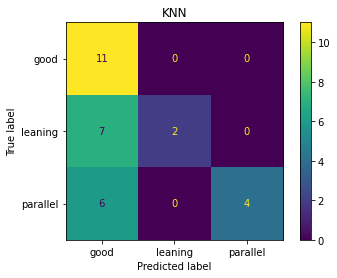

{'Classifier': 'KNN', 'Accuracy': 0.5666666666666667, 'Precision': 0.8194444444444443, 'Recall': 0.5407407407407407, 'F1 Score': 0.5666666666666667}


In [10]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video, knc_model))
    
scores = evaluate_model('KNN', y_pred, True)
model_scores.append(scores)
print(scores)

## Neural Network Model

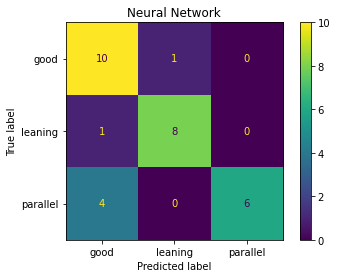

{'Classifier': 'Neural Network', 'Accuracy': 0.8, 'Precision': 0.8518518518518517, 'Recall': 0.7993265993265993, 'F1 Score': 0.8000000000000002}


In [11]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video, mlp_model))
    
scores = evaluate_model('Neural Network', y_pred, True)
model_scores.append(scores)
print(scores)

In [12]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

        good       0.67      0.91      0.77        11
     leaning       0.89      0.89      0.89         9
    parallel       1.00      0.60      0.75        10

    accuracy                           0.80        30
   macro avg       0.85      0.80      0.80        30
weighted avg       0.84      0.80      0.80        30



## Gaussian NB Model

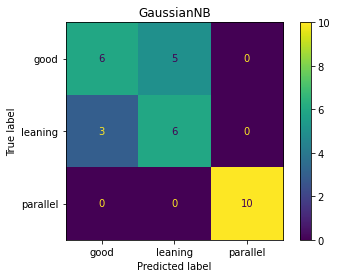

{'Classifier': 'GaussianNB', 'Accuracy': 0.7333333333333333, 'Precision': 0.7373737373737373, 'Recall': 0.7373737373737373, 'F1 Score': 0.7333333333333333}


In [13]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video, gnb_model))
    
scores = evaluate_model('GaussianNB', y_pred, True)
model_scores.append(scores)
print(scores)

## Multinomial NB Model

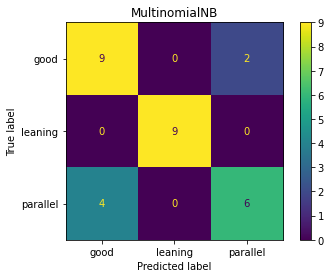

{'Classifier': 'MultinomialNB', 'Accuracy': 0.8, 'Precision': 0.8141025641025642, 'Recall': 0.8060606060606061, 'F1 Score': 0.8000000000000002}


In [14]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video, mnb_model))
    
scores = evaluate_model('MultinomialNB', y_pred, True)
model_scores.append(scores)
print(scores)

## Linear SVC Model

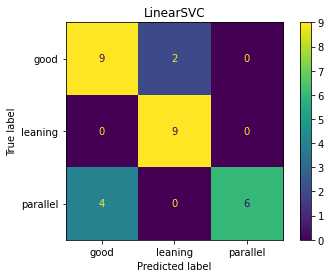

{'Classifier': 'LinearSVC', 'Accuracy': 0.8, 'Precision': 0.8368298368298368, 'Recall': 0.8060606060606061, 'F1 Score': 0.8000000000000002}


In [15]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video, svc_model))
    
scores = evaluate_model('LinearSVC', y_pred, True)
model_scores.append(scores)
print(scores)

## Best Performers

In [16]:
eval_scores = pd.DataFrame(model_scores)
eval_scores = eval_scores.sort_values(by = ['F1 Score'], ascending = False)
eval_scores

,Classifier,Accuracy,Precision,Recall,F1 Score
1,Neural Network,0.800000,0.851852,0.799327,0.800000
3,MultinomialNB,0.800000,0.814103,0.806061,0.800000
4,LinearSVC,0.800000,0.836830,0.806061,0.800000
2,GaussianNB,0.733333,0.737374,0.737374,0.733333
0,KNN,0.566667,0.819444,0.540741,0.566667
